# Part 1 of 8: Import key packages and data

In [ ]:
### Import key packages and data

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
!pip install statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import scipy.stats as stats
from scipy.stats import skew, kurtosis, kstest, shapiro, normaltest, anderson, kstest, wilcoxon, mannwhitneyu, spearmanr, boxcox, yeojohnson
from sklearn.preprocessing import PowerTransformer
!pip install fredapi
from fredapi import Fred

#-- import data using URL

url_MovieData_ShareLink =  'https://drive.google.com/file/d/1nm0iqtMvHCxcZVU7aQSxRmsEgSpof4Uu/view?usp=sharing'
url_MovieData = 'https://drive.google.com/uc?id=' + url_MovieData_ShareLink.split('/')[-2]

df = pd.read_csv(url_MovieData)

#-- view columns and number of rows

print(f'Columns in df: {[x for x in df.columns]}')
print(f'Number of rows: {len(df)}')


Columns in df: ['name', 'rating', 'genre', 'year', 'released', 'score', 'votes', 'director', 'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime']
Number of rows: 7668


# Part 2: Perform data cleaning

### View dtypes
name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

### Check that the datetime column, release_date, is working.
                              released release_date release_country
7663  October 23, 2020 (United States)   2020-10-23   United States
7664  February 7, 2020 (United States)   2020-02-07   United States
7665         April 27, 2020 (Cameroon)   2020-04-27        Cameroon
7666   October 1, 2020 (United States)   2020-10-01   United States
7667   August 19, 2020 (United States)   2020-08-19   United States



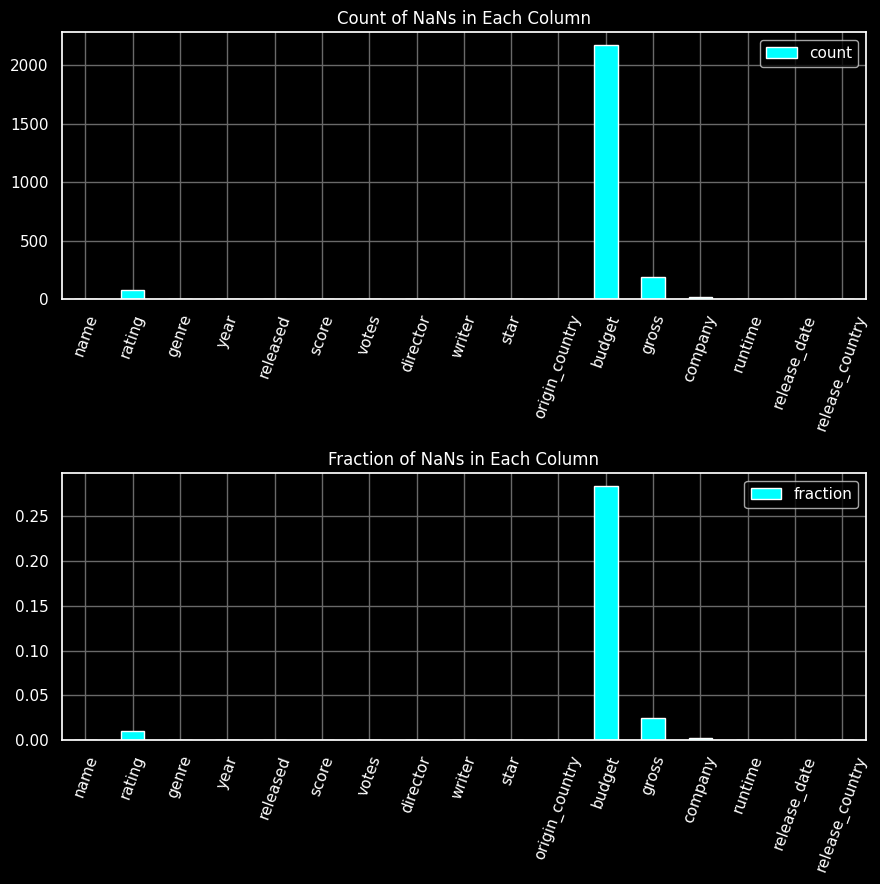

In [ ]:
### Data cleaning part 1/3 - format column names & view count of NaN values

#-- Check types of columns

print('### View dtypes')
print(df.dtypes)
print('')

#-- format "released" column to be datetime format
#--- initial format is this: 'June 13, 1980 (United States)'

df['release_date_list'] = df['released'].apply(lambda y: [x.strip() for x in re.split(r'[()]', str(y))[:-1]])
df['release_date'] = df['release_date_list'].str[0]
df['release_country'] = df['release_date_list'].str[1]
df['release_date'] = pd.to_datetime(df['release_date'])

df = df.drop('release_date_list', axis=1)

print('### Check that the datetime column, release_date, is working.')
print(df[['released','release_date','release_country']].tail())
print('')

#-- rename "country" column to "origin_country" for clarity

df.rename(columns={'country':'origin_country'}, inplace=True)

#-- drop rows with 0 in budget or gross column values

df = df[(df['budget'] != 0) & (df['gross'] != 0)]

#-- Get count and fraction of NaNs in columns

df_NanCount = pd.DataFrame(df.isnull().sum())
df_NanFrac = df_NanCount / len(df)

df_NanCount.columns = ['count']
df_NanFrac.columns = ['fraction']

#-- plot the count and fration of NaNs

from matplotlib import gridspec
plt.style.context("dark_background")
plt.style.use('dark_background')
sns.set(rc={'axes.facecolor': 'k', 'figure.facecolor': 'k'})
plt.style.use("dark_background")
num_colors = 4
color = plt.cm.cool(np.linspace(0, 1, num_colors))
cyc = plt.cycler('color', color)
plt.rc('axes', prop_cycle=cyc)

fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], width_ratios=[1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

df_NanCount.plot.bar(rot=70, ax=ax1, title='Count of NaNs in Each Column')
df_NanFrac.plot.bar(rot=70, ax=ax2, title='Fraction of NaNs in Each Column')

ax1.grid(c='dimgray')
ax2.grid(c='dimgray')

plt.tight_layout()



In [ ]:
### Data cleaning part 2/3 - drop rows where key columns have NaNs

#-- drop rows where any of the following columns are NaN:
#--- name, year, director, star, gross, budget, year, released

RowCount_PreDrop = len(df)

list_KeyCols = ['name', 'year', 'director', 'star', 'gross', 'budget', 'year', 'released']

df.dropna(how='any', subset=list_KeyCols, inplace=True)

RowCount_PostDrop = len(df)
RowCount_dropped = RowCount_PreDrop - RowCount_PostDrop

print(f'Number of rows initially: {RowCount_PreDrop}')
print(f'Number of rows after dropping NaNs: {RowCount_PostDrop}')
print(f'Number of rows dropped: {RowCount_dropped}')


Number of rows initially: 7668
Number of rows after dropping NaNs: 5436
Number of rows dropped: 2232


In [ ]:
### Data cleaning part 3/3 - identifying potential outliers with Tukey Test

def get_tukey_outliers(df, col, multiplier=1.5):
  dfz = df.copy()[[col]].dropna()
  q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
  IQR = q3 - q1
  list_outliers = [x for x in dfz[col].values if (x > q3 + multiplier*IQR) | (x < q1 - multiplier*IQR)]
  return list_outliers

dfo = df.copy()

list_NumericCols = dfo.select_dtypes(include=np.number).columns.tolist()

dict_ColOutliers = {}

for col in list_NumericCols:
  list_outliers = get_tukey_outliers(df=dfo, col=col, multiplier=2.5)
  dict_ColOutliers[col] = list_outliers

  count_outliers = len(list_outliers)
  frac_outliers = count_outliers / len(dfo[col])

  print(f'### Looking at column [{col}]')
  print(f'# Number of potential outliers: {len(list_outliers)}')
  print(f'# Fraction of data that represents: {100*frac_outliers:.1f}%')
  print(f'# View 5 potential outliers')
  print(list_outliers[:5])
  print('')



### Looking at column [year]
# Number of potential outliers: 0
# Fraction of data that represents: 0.0%
# View 5 potential outliers
[]

### Looking at column [score]
# Number of potential outliers: 14
# Fraction of data that represents: 0.3%
# View 5 potential outliers
[2.2, 2.5, 2.5, 2.3, 2.5]

### Looking at column [votes]
# Number of potential outliers: 313
# Fraction of data that represents: 5.8%
# View 5 potential outliers
[927000.0, 1200000.0, 905000.0, 710000.0, 766000.0]

### Looking at column [budget]
# Number of potential outliers: 247
# Fraction of data that represents: 4.5%
# View 5 potential outliers
[175000000.0, 200000000.0, 160000000.0, 140000000.0, 140000000.0]

### Looking at column [gross]
# Number of potential outliers: 343
# Fraction of data that represents: 6.3%
# View 5 potential outliers
[538375067.0, 389925971.0, 792910554.0, 475106177.0, 381906762.0]

### Looking at column [runtime]
# Number of potential outliers: 36
# Fraction of data that represents: 0.7%
# 

# Part 3: Access the API for St Louis FRED; get inflation data & adjust for inflation

In [ ]:
### Access the API for St Louis FRED to get inflation data
#-- This is needed for interpreting historical data on budgets & gross revenue

my_fred_key = 'd1fb6bb0ee938c0cbd678229a9ad2a71'
fred = Fred(api_key=my_fred_key)

series_cpi = fred.get_series('CPIAUCSL')

df_cpi = series_cpi.to_frame()
df_cpi.columns = ['CPI']
df_cpi.index = pd.to_datetime(df_cpi.index, format='%Y-%m-%d')
df_cpi.sort_index(ascending=True, inplace=True)

print('Successfully connected to FRED API.')


Successfully connected to FRED API.


In [ ]:
### Adjust budget & gross revenue columns for inflation. Make functions to help.

def get_cpi(df_inflation, date):
  try:
    value_cpi = df_inflation['CPI'].loc[date]
    return value_cpi
  except:
    return np.NaN

def cpi_adjust(df_inflation, df_data, date_col, value_col):
  cpi_recent = df_inflation.loc[df_inflation.index[-1], 'CPI']
  dfz = df_data[[date_col, value_col]].copy()
  dfz['inflation_date'] = dfz[date_col].apply(lambda dt: dt.replace(day=1))
  dfz['adj_col'] = np.NaN
  for index, row in dfz.iterrows():
    date_cpi = row['inflation_date']
    cpi_old = get_cpi(df_inflation, date_cpi)
    dfz['adj_col'] = dfz[value_col]*(cpi_recent/cpi_old)
  return dfz['adj_col']

df['budget_adj'] = cpi_adjust(df_inflation=df_cpi, df_data=df, date_col='release_date', value_col='budget')
df['gross_adj'] = cpi_adjust(df_inflation=df_cpi, df_data=df, date_col='release_date', value_col='gross')

print(df[['name','release_date','budget','budget_adj','gross','gross_adj']].tail(7))

df_backup = df.copy()


                      name release_date       budget    budget_adj  \
7645         Birds of Prey   2020-02-07   84500000.0  1.008937e+08   
7646     The Invisible Man   2020-02-28    7000000.0  8.358054e+06   
7648     Bad Boys for Life   2020-01-17   90000000.0  1.074607e+08   
7649    Sonic the Hedgehog   2020-02-14   85000000.0  1.014907e+08   
7650              Dolittle   2020-01-17  175000000.0  2.089513e+08   
7651  The Call of the Wild   2020-02-21  135000000.0  1.611910e+08   
7652     The Eight Hundred   2020-08-28   80000000.0  9.552062e+07   

            gross     gross_adj  
7645  201858461.0  2.410206e+08  
7646  143151000.0  1.709234e+08  
7648  426505244.0  5.092505e+08  
7649  319715683.0  3.817430e+08  
7650  245487753.0  2.931143e+08  
7651  111105497.0  1.326608e+08  
7652  461421559.0  5.509409e+08  


# Part 4: See how budgets, revenues, and scores vary across genres of movies

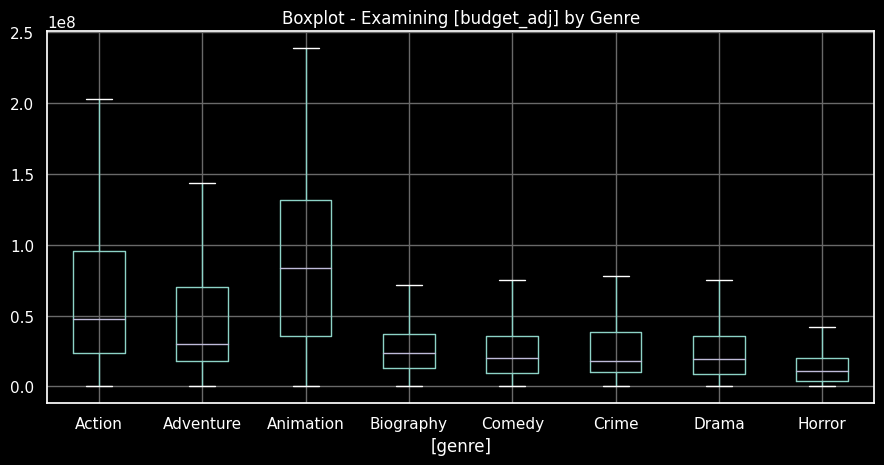

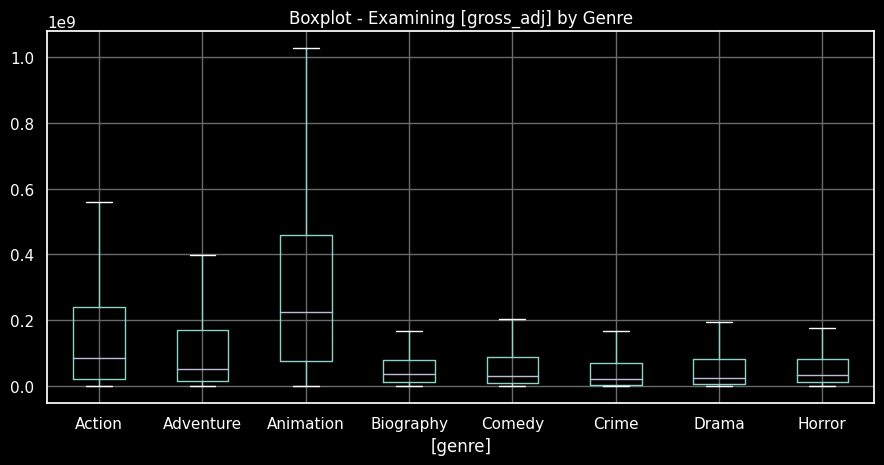

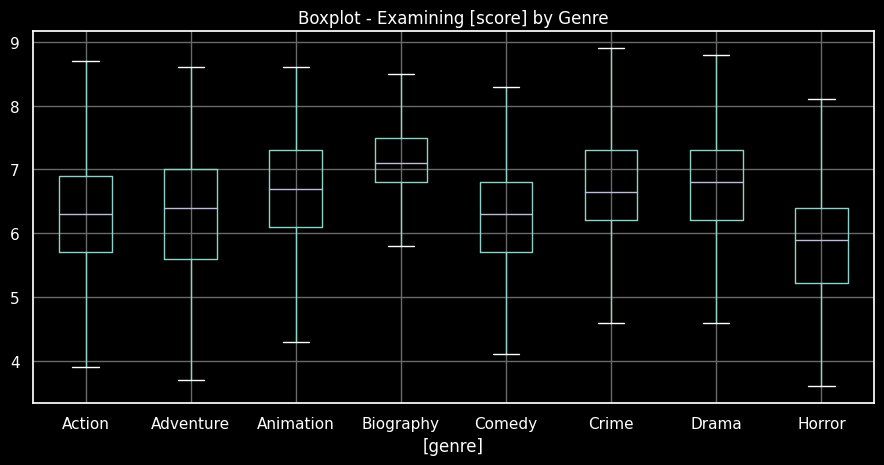

In [ ]:
### see how budgets, revenues, and scores vary across genres of movies (boxplots)

#-- filter out genres with less than 100 movies in them

df_GenreCounts = df.groupby('genre').count()[['name']].rename(columns={'name':'count'})
df_GenreCounts['movie_genre'] = df_GenreCounts.index
df_GenreCounts = df_GenreCounts[(df_GenreCounts['count'] >= 100)]

list_KeyGenres = df_GenreCounts['movie_genre'].unique()

df_GenreFilt = df.copy()[(df['genre'].isin(list_KeyGenres))]

list_KeyVars = ['budget_adj','gross_adj','score']

#-- make boxplots; each shows how a metric varies across genres

for KeyVar in list_KeyVars:

  from matplotlib import gridspec
  plt.style.use('dark_background')
  plt.style.context("dark_background")

  fig = plt.figure(figsize=(9, 5))
  gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1])
  ax1 = plt.subplot(gs[0])

  boxplot_title = f'Boxplot - Examining [{KeyVar}] by Genre'

  df_GenreFilt[[KeyVar,'genre']].boxplot(by='genre', ax=ax1, showfliers=False, capprops={'color': 'white'})
  ax1.set_title(boxplot_title)
  ax1.get_figure().suptitle("")

  ax1.grid(c='dimgray')

  plt.tight_layout()


# Part 5: Find pairs of genres with a statistically significant difference in mean budgets

In [ ]:
### testing for a statistically significant difference in mean budgets, by genre

#-- get list of key genres; find all possible pairs of them

df_GenreCounts = df.groupby('genre').count()[['name']].rename(columns={'name':'count'})
df_GenreCounts['movie_genre'] = df_GenreCounts.index
df_GenreCounts = df_GenreCounts[(df_GenreCounts['count'] >= 100)]

list_KeyGenres = df_GenreCounts['movie_genre'].unique()

list_pairs = list(itertools.combinations(list_KeyGenres, 2))
list_pairs = [list(x) for x in list_pairs if x in list_pairs] # make list of lists, not tuples.

#-- iterate through pairs; compare mean value of budget_adj of genres in each pair.

var_of_interest = 'budget_adj'
conf_level = 0.05

df_DiffMeanTest = pd.DataFrame(columns=['genre_x','genre_y','direction','pval','PctSpread_BetwMeans','NumObservs_x','NumObservs_y'])

for num_pair, pair in enumerate(list_pairs):
  genre_x, genre_y = pair[0], pair[1]
  x_series = df[(df['genre']==genre_x)]['budget_adj']
  y_series = df[(df['genre']==genre_y)]['budget_adj']

  pct_MeanDiff = (x_series.mean() - y_series.mean()) / y_series.mean()

  # try a test to see if x mean is higher than y mean

  if len(x_series) == len(y_series):
    stat_greater, pval_greater = wilcoxon(x=x_series, y=y_series, alternative='greater')
  else:
    stat_greater, pval_greater = mannwhitneyu(x=x_series, y=y_series, alternative='greater')

  if pval_greater < conf_level:
    df_DiffMeanTest.loc[num_pair] = genre_x, genre_y, 'greater', pval_greater, pct_MeanDiff, len(x_series), len(y_series)

   # try a test to see if x mean is lower than y mean

  else:

    if len(x_series) == len(y_series):
      stat_greater, pval_less = wilcoxon(x=x_series, y=y_series, alternative='less')
    else:
      stat_greater, pval_less = mannwhitneyu(x=x_series, y=y_series, alternative='less')

    if pval_less < conf_level:
      df_DiffMeanTest.loc[num_pair] = genre_x, genre_y, 'less', pval_less, pct_MeanDiff, len(x_series), len(y_series)

  # show progress

  if (num_pair + 1) % len(list_pairs)//10 == 0:
    print(f'# Done with pair {num_pair + 1} of {len(list_pairs)}')

#-- Sort results dataframe by highest mean difference (percent); view sorted dataframe

if len(df_DiffMeanTest) > 1:
  df_DiffMeanTest.sort_values(by=['PctSpread_BetwMeans'], ascending=False, inplace=True)

print('')
print('### Viewing top 10 tresults with most significant differences in means')
print(df_DiffMeanTest.head(10))



# Done with pair 1 of 28
# Done with pair 2 of 28
# Done with pair 3 of 28
# Done with pair 4 of 28
# Done with pair 5 of 28
# Done with pair 6 of 28
# Done with pair 7 of 28
# Done with pair 8 of 28
# Done with pair 9 of 28
# Done with pair 28 of 28

### Viewing top 10 tresults with most significant differences in means
      genre_x    genre_y direction           pval  PctSpread_BetwMeans  \
17  Animation     Horror   greater   1.441550e-56             4.718451   
6      Action     Horror   greater   8.144458e-67             3.392297   
12  Adventure     Horror   greater   5.289081e-34             2.455692   
15  Animation      Crime   greater   9.410212e-47             2.369416   
14  Animation     Comedy   greater   6.567310e-66             2.335285   
16  Animation      Drama   greater   5.727209e-59             2.279416   
13  Animation  Biography   greater   7.996598e-37             1.998814   
4      Action      Crime   greater   2.056178e-45             1.588022   
3      Acti

# Part 6: View evolution of mean budget over time, one genre at a time

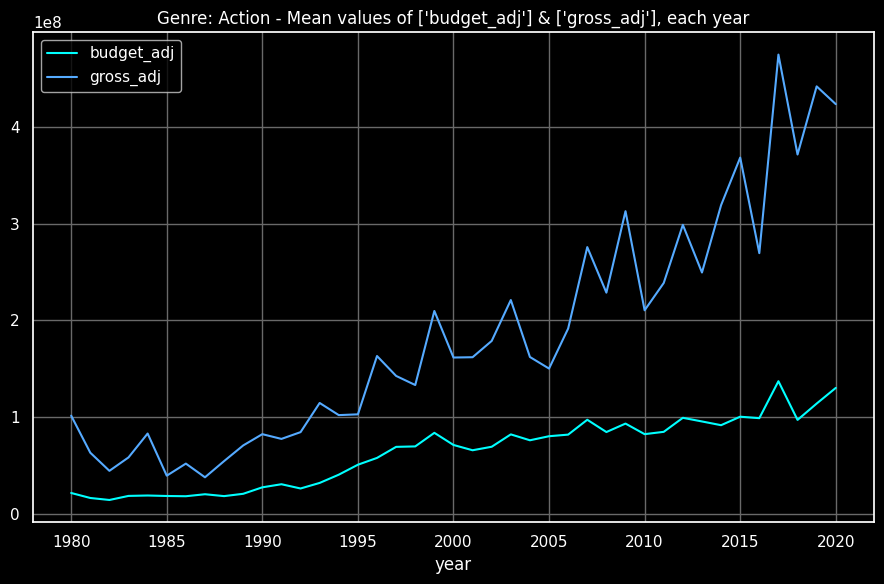

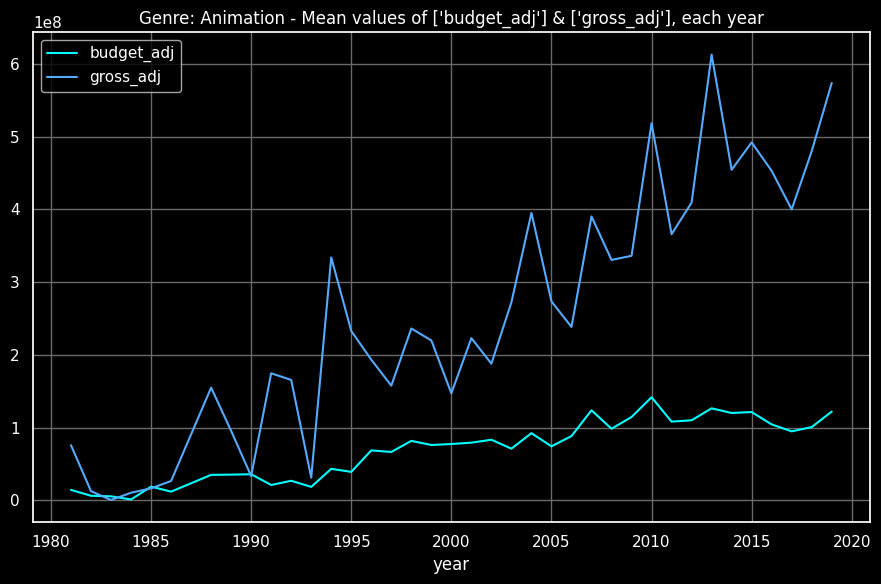

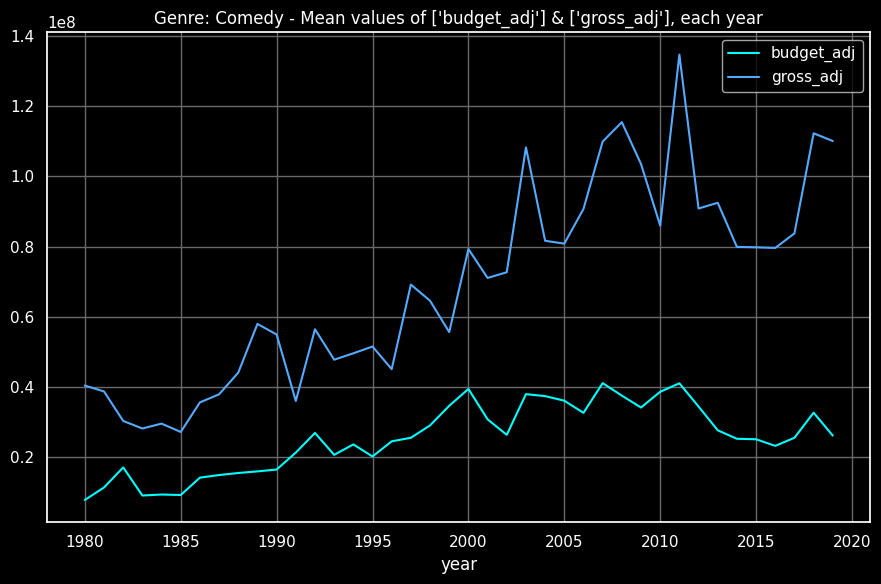

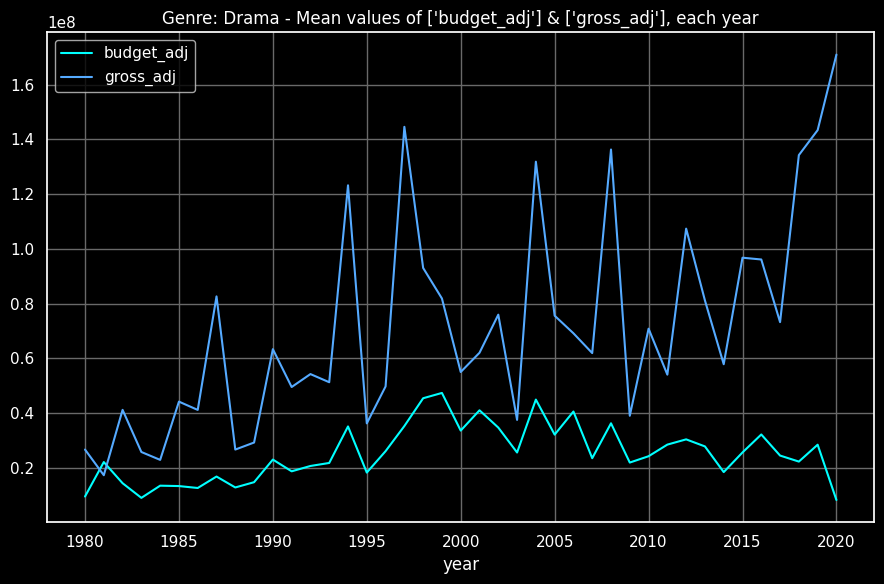

In [ ]:
#-- View evolution of means over time, one genre at a time; show some examples

list_genre_exs = ['Action','Animation','Comedy','Drama']

for genre in list_genre_exs[:]:

  df_MeansByYr = df[(df['genre'] == genre)].groupby('year')[['budget_adj','gross_adj']].mean()

  # plot

  from matplotlib import gridspec
  plt.style.context("dark_background")
  plt.style.use('dark_background')
  sns.set(rc={'axes.facecolor': 'k', 'figure.facecolor': 'k'})
  plt.style.use("dark_background")
  num_colors = 4
  color = plt.cm.cool(np.linspace(0, 1, num_colors))
  cyc = plt.cycler('color', color)
  plt.rc('axes', prop_cycle=cyc)

  fig = plt.figure(figsize=(9, 6))
  gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1])
  ax1 = plt.subplot(gs[0])

  ax1.grid(c='dimgray')
  ax1.yaxis.set_label_position("left")

  df_MeansByYr[['budget_adj','gross_adj']].plot(ax=ax1, logy=False, title=f"Genre: {genre} - Mean values of ['budget_adj'] & ['gross_adj'], each year")

  # not using logy (just to make y-axis look more readable).

  plt.tight_layout()


# Part 7: View distributions of numerical columns; assess skew & normality

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_moresta

### View df of rejection bools - if true, normality is rejected
           kstest shapiro D'Agostino's K^2 Anderson-Darling  bool_normal
year         True    True             True             True            0
score        True    True             True             True            0
votes        True    True             True             True            0
budget       True    True             True             True            0
gross        True    True             True             True            0
runtime      True    True             True             True            0
budget_adj   True    True             True             True            0
gross_adj    True    True             True             True            0

Index(['year_transf_YeoJohnson', 'score_transf_BoxCox', 'votes_transf_BoxCox',
       'budget_transf_YeoJohnson', 'gross_transf_BoxCox',
       'runtime_transf_BoxCox', 'budget_adj_transf_YeoJohnson',
       'gross_adj_transf_BoxCox'],
      dtype='object')


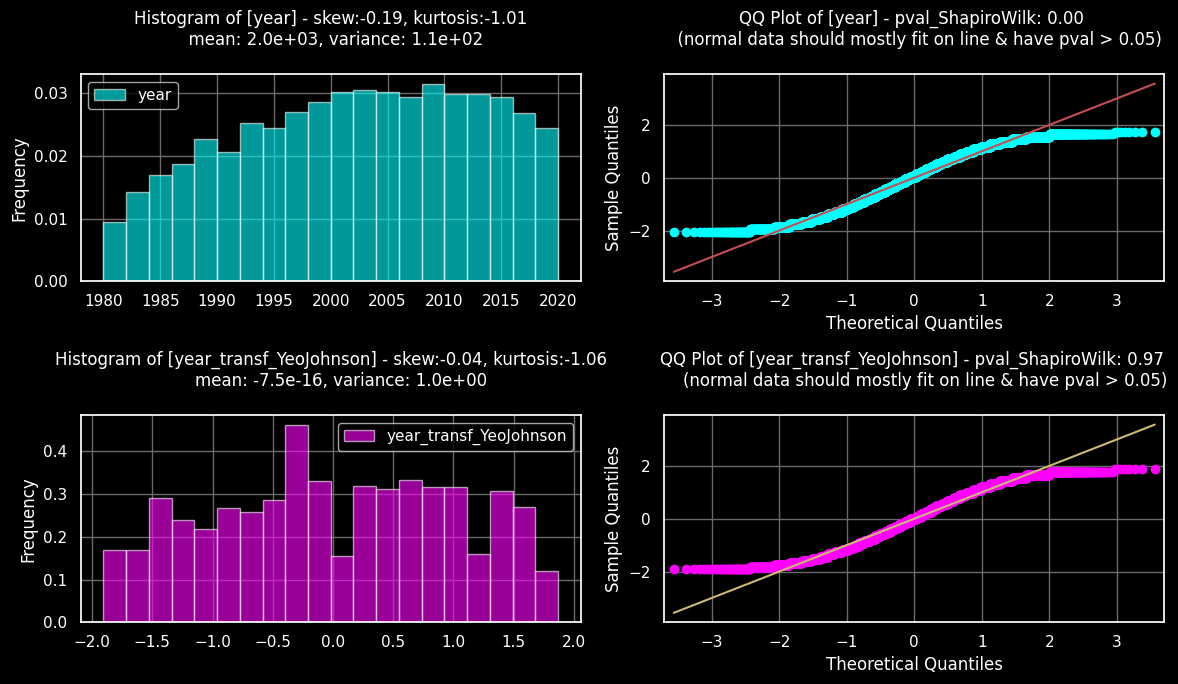

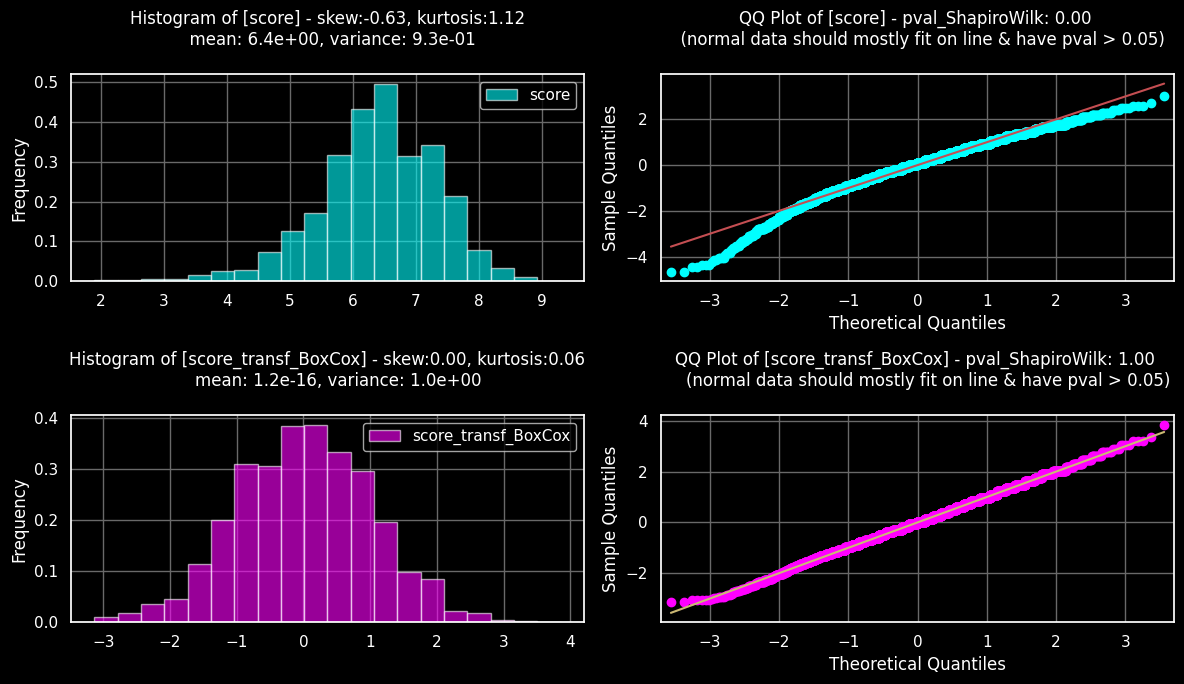

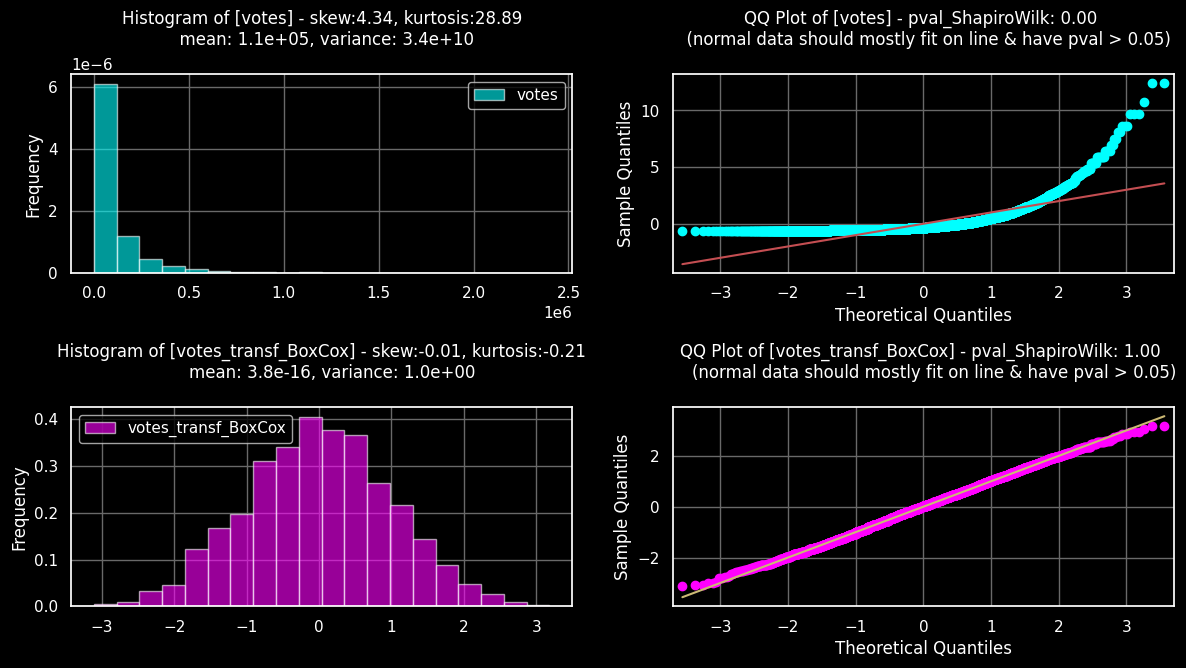

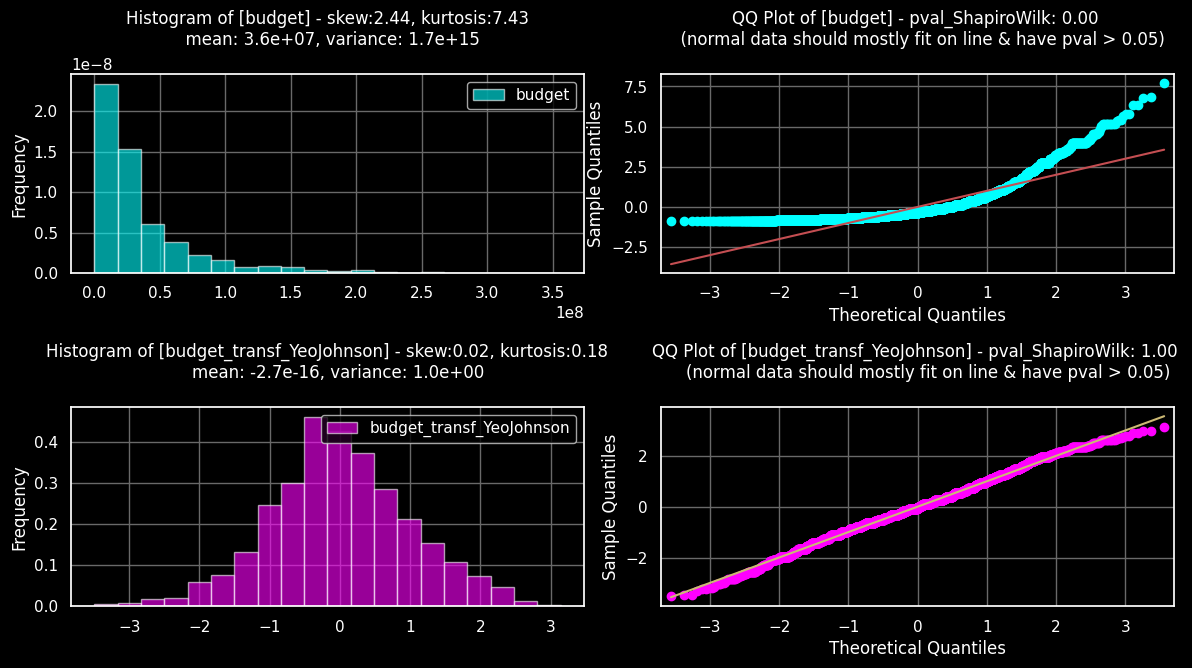

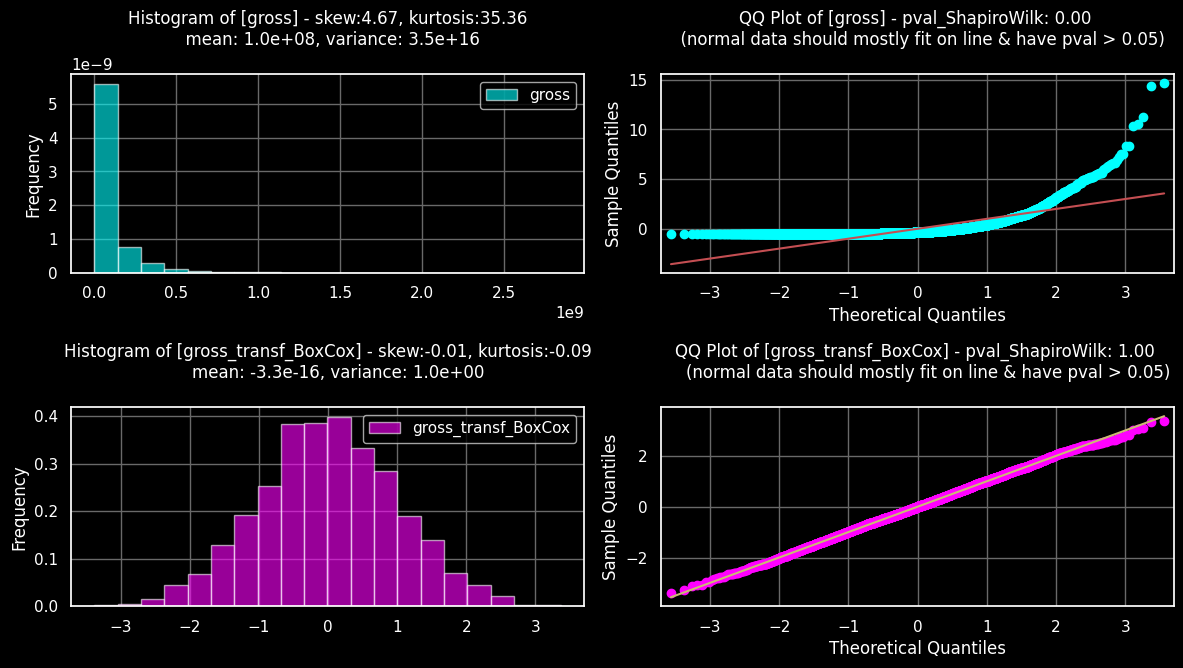

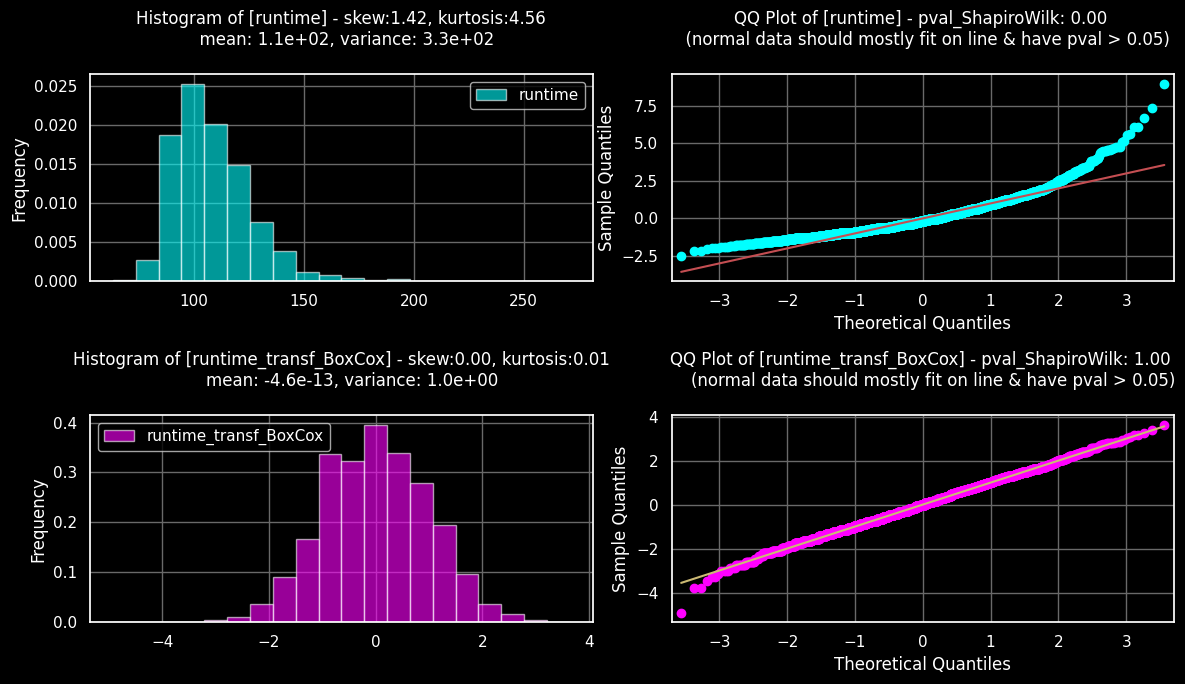

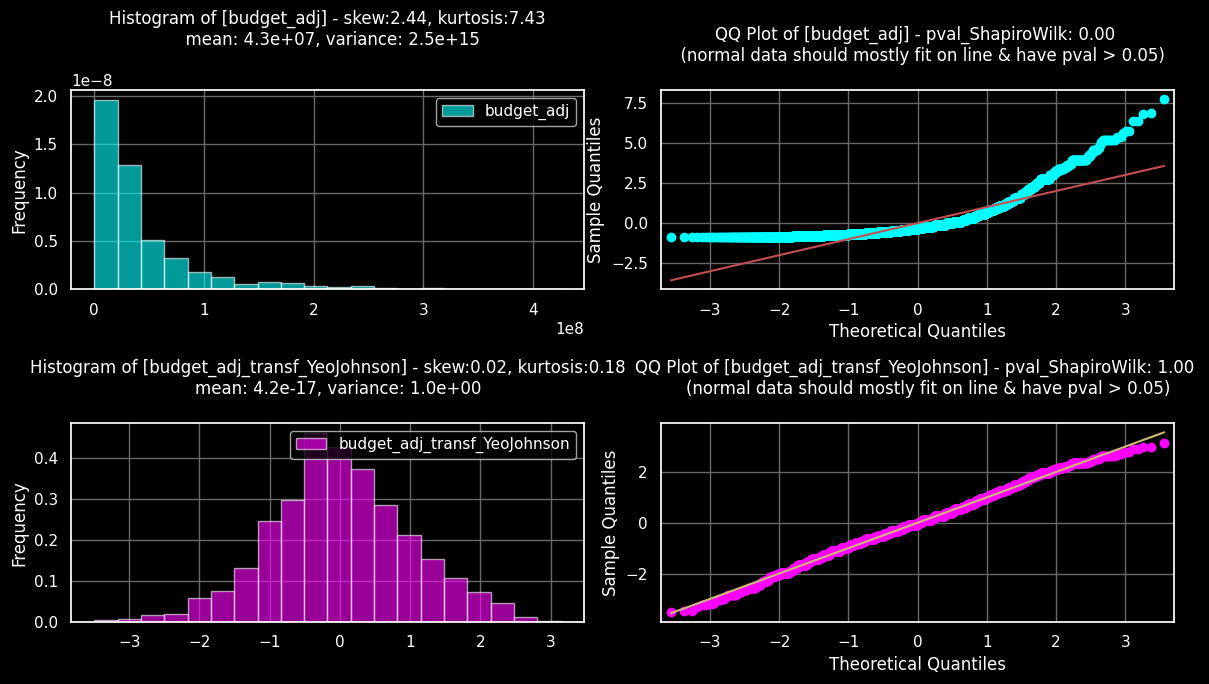

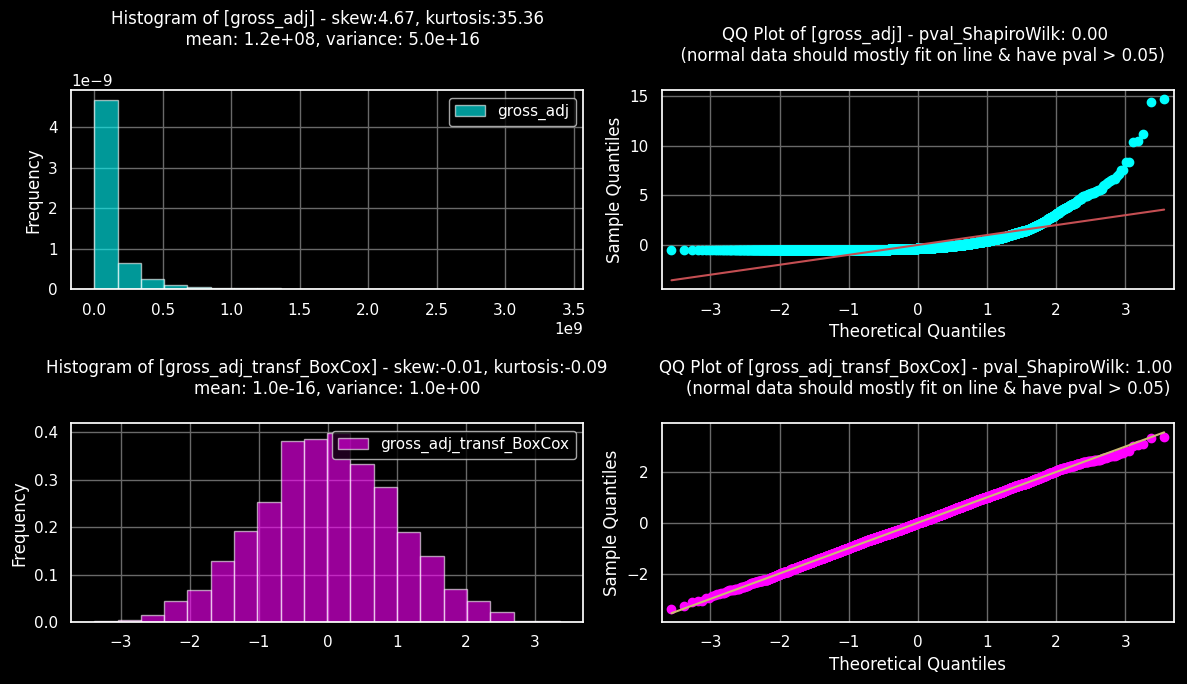

In [ ]:
### View distributions of numerical columns. Try to transform to achieve normality

dfs = df_backup.copy()

list_NumericCols = dfs.select_dtypes(include=np.number).columns.tolist()

alpha_NormTests = 0.05 # either 0.01, 0.025, or 0.05

df_RejectBools = pd.DataFrame(index=list_NumericCols, columns=['kstest', 'shapiro', "D'Agostino's K^2", "Anderson-Darling"])

for col in list_NumericCols[:]:
  col_mean = dfs[col].mean()
  col_var = dfs[col].var()
  col_skew = skew(dfs[col], nan_policy='omit')
  col_kurtosis = kurtosis(df[col], nan_policy='omit')

  # run normality tests

  TestStat_KS, pval_KS = stats.kstest(dfs[col].dropna(),'norm')
  BoolReject_KS = pval_KS < alpha_NormTests

  TestStat_shapiro, pval_shapiro = shapiro(dfs[col].dropna())
  BoolReject_shapiro = pval_shapiro < alpha_NormTests

  TestStat_dagostino, pval_dagostino = normaltest(dfs[col].dropna())
  BoolReject_dagostino = pval_dagostino < alpha_NormTests

  TestStat_AD, crit_AD, sig_AD = anderson(dfs[col].dropna(), dist='norm')
  dict_AD = {}
  for num_i, level in enumerate(sig_AD):
    crit_val = crit_AD[num_i]
    dict_AD[level/100] = crit_val
  BoolReject_AD = TestStat_AD > dict_AD[alpha_NormTests]

  df_RejectBools.loc[col] = BoolReject_KS, BoolReject_shapiro, BoolReject_dagostino, BoolReject_AD

  # attempt transforms; rank the best ones (by lowest skew, highest pval)

  list_TransformTypes = ['NaturalLog','SquareRoot','BoxCox','YeoJohnson']

  df_TransformMetrics = pd.DataFrame(index=list_TransformTypes+['NoTransform'], columns=['transform_type','pval_ShapiroTest','skew'])
  df_TransformMetrics.loc['NoTransform'] = 'NoTransform', pval_shapiro, col_skew

  dict_TransformCols = {}
  dict_TransformCols['NoTransform'] = df[col]

  dfz = dfs[[col for col in df.columns if 'transform' not in col]]

  for TransformType in list_TransformTypes:

    if TransformType=='NaturalLog':
      try:
        dfz[f'{col}_transf_{TransformType}'] = np.log(dfz[col])
        TestStat_shapiro_z, pval_shapiro_z = shapiro(dfz[f'{col}_transf_{TransformType}'].dropna())
        col_skew_z = skew(dfz[f'{col}_transf_{TransformType}'], nan_policy='omit')
        df_TransformMetrics.loc[TransformType] = TransformType, pval_shapiro_z, col_skew_z
        dict_TransformCols[TransformType] = dfz[f'{col}_transf_{TransformType}']
      except Exception as e:
        pass

    if TransformType=='SquareRoot':
      try:
        dfz[f'{col}_transf_{TransformType}'] = np.sqrt(dfz[col])
        TestStat_shapiro_z, pval_shapiro_z = shapiro(dfz[f'{col}_transf_{TransformType}'].dropna())
        col_skew_z = skew(dfz[f'{col}_transf_{TransformType}'], nan_policy='omit')
        df_TransformMetrics.loc[TransformType] = TransformType, pval_shapiro_z, col_skew_z
        dict_TransformCols[TransformType] = dfz[f'{col}_transf_{TransformType}']
      except Exception as e:
        pass

    if TransformType=='BoxCox':
      try:
        data = dfz[col].values.reshape((len(dfz[col]),1))
        power = PowerTransformer(method='box-cox', standardize=True)
        data_trans = power.fit_transform(data)
        dfz[f'{col}_transf_{TransformType}'] = data_trans
        TestStat_shapiro_z, pval_shapiro_z = shapiro(dfz[f'{col}_transf_{TransformType}'].dropna())
        col_skew_z = skew(dfz[f'{col}_transf_{TransformType}'], nan_policy='omit')
        df_TransformMetrics.loc[TransformType] = TransformType, pval_shapiro_z, col_skew_z
        dict_TransformCols[TransformType] = dfz[f'{col}_transf_{TransformType}']
      except Exception as e:
        pass

    if TransformType=='YeoJohnson':
      try:
        data = dfz[col].values.reshape((len(dfz[col]),1))
        power = PowerTransformer(method='yeo-johnson', standardize=True)
        data_trans = power.fit_transform(data)
        dfz[f'{col}_transf_{TransformType}'] = data_trans
        TestStat_shapiro_z, pval_shapiro_z = shapiro(dfz[f'{col}_transf_{TransformType}'].dropna())
        col_skew_z = skew(dfz[f'{col}_transf_{TransformType}'], nan_policy='omit')
        df_TransformMetrics.loc[TransformType] = TransformType, pval_shapiro_z, col_skew_z
        dict_TransformCols[TransformType] = dfz[f'{col}_transf_{TransformType}']
      except Exception as e:
        pass

  if len(df_TransformMetrics) > 1:
    df_TransformMetrics['skew_abs'] = df_TransformMetrics['skew'].abs()

    df_TransformMetrics.sort_values(by=['skew_abs','pval_ShapiroTest'], ascending=[True, False], inplace=True)
    TransformType_best = df_TransformMetrics['transform_type'].iloc[0]

    if TransformType_best != 'NoTransform':
      dfs[f'{col}_transf_{TransformType_best}'] = dict_TransformCols[TransformType_best]

  # generate plots

  from matplotlib import gridspec
  plt.style.context("dark_background")
  plt.style.use('dark_background')
  sns.set(rc={'axes.facecolor': 'k', 'figure.facecolor': 'k'})
  plt.style.use("dark_background")
  num_colors = 4
  color = plt.cm.cool(np.linspace(0, 1, num_colors))
  cyc = plt.cycler('color', color)
  plt.rc('axes', prop_cycle=cyc)

  fig = plt.figure(figsize=(12, 7))
  gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])
  ax3 = plt.subplot(gs[2])
  ax4 = plt.subplot(gs[3])

  title_hist = f"""Histogram of [{col}] - skew:{col_skew:.2f}, kurtosis:{col_kurtosis:.2f}
  mean: {col_mean:{".2f" if len(str(col_mean))<5 else ".1e"}}, variance: {col_var:{".2f" if len(str(col_var))<5 else ".1e"}}
  """

  title_QQ = f"""QQ Plot of [{col}] - pval_ShapiroWilk: {pval_shapiro:.2f}
  (normal data should mostly fit on line & have pval > 0.05)
  """

  dfs[[col]].plot.hist(alpha=0.6, density=1, bins=20, ax=ax1, title=title_hist)
  sm.graphics.qqplot(data=df[col].dropna(), line='s', fit=True, ax=ax2)

  ax2.set_title(title_QQ)

  # use bottom row of plots if a transformation was successful.

  if TransformType_best != 'NoTransform':
    col_transf = f'{col}_transf_{TransformType_best}'

    col_transf_mean = dfs[col_transf].mean()
    col_transf_var = dfs[col_transf].var()
    col_transf_skew = skew(dfs[col_transf], nan_policy='omit')
    col_transf_kurtosis = kurtosis(dfs[col_transf], nan_policy='omit')

    TestStat_transf_shapiro, pval_transf_shapiro = shapiro(dfs[col_transf].dropna())
    BoolReject_transf_shapiro = pval_transf_shapiro < alpha_NormTests

    title_hist = f"""Histogram of [{col_transf}] - skew:{col_transf_skew:.2f}, kurtosis:{col_transf_kurtosis:.2f}
    mean: {col_transf_mean:{".2f" if len(str(col_transf_mean))<5 else ".1e"}}, variance: {col_transf_var:{".2f" if len(str(col_transf_var))<5 else ".1e"}}
    """

    title_QQ = f"""QQ Plot of [{col_transf}] - pval_ShapiroWilk: {TestStat_transf_shapiro:.2f}
    (normal data should mostly fit on line & have pval > 0.05)
    """

    dfs[[col_transf]].plot.hist(alpha=0.6, density=1, bins=20, ax=ax3, title=title_hist, color = plt.cm.spring(np.linspace(0, 1, num_colors)))
    sm.graphics.qqplot(data=dfs[col_transf].dropna(), line='s', fit=True, ax=ax4, markerfacecolor='magenta', markeredgecolor='magenta')

    ax4.set_title(title_QQ)
    ax4.get_lines()[1].set_color("y")

  else:
    if ('BoxCox' not in df_TransformMetrics['transform_type']) & ('YeoJohnson' not in df_TransformMetrics['transform_type']):
      ax3_title = """No transformations that improved normality
      Unable to perform BoxCox or YeoJohnson transformation
      """
    else:
      ax3_title = """No transformations that improved normality"""

    ax3.set_title(ax3_title)
    ax4.set_title('QQ Plot - No transformation to display')

  # note: when plotting the transformed distribution, set the color to be different.

  ax1.grid(c='dimgray')
  ax2.grid(c='dimgray')
  ax3.grid(c='dimgray')
  ax4.grid(c='dimgray')

  plt.tight_layout()

df_RejectBools['bool_normal'] = (df_RejectBools[['kstest', 'shapiro', "D'Agostino's K^2", "Anderson-Darling"]].sum(axis=1) == 0)*1

print('### View df of rejection bools - if true, normality is rejected')
print(df_RejectBools)
print('')

print(dfs.filter(regex='_transf').columns)


# Part 8: Explore correlations

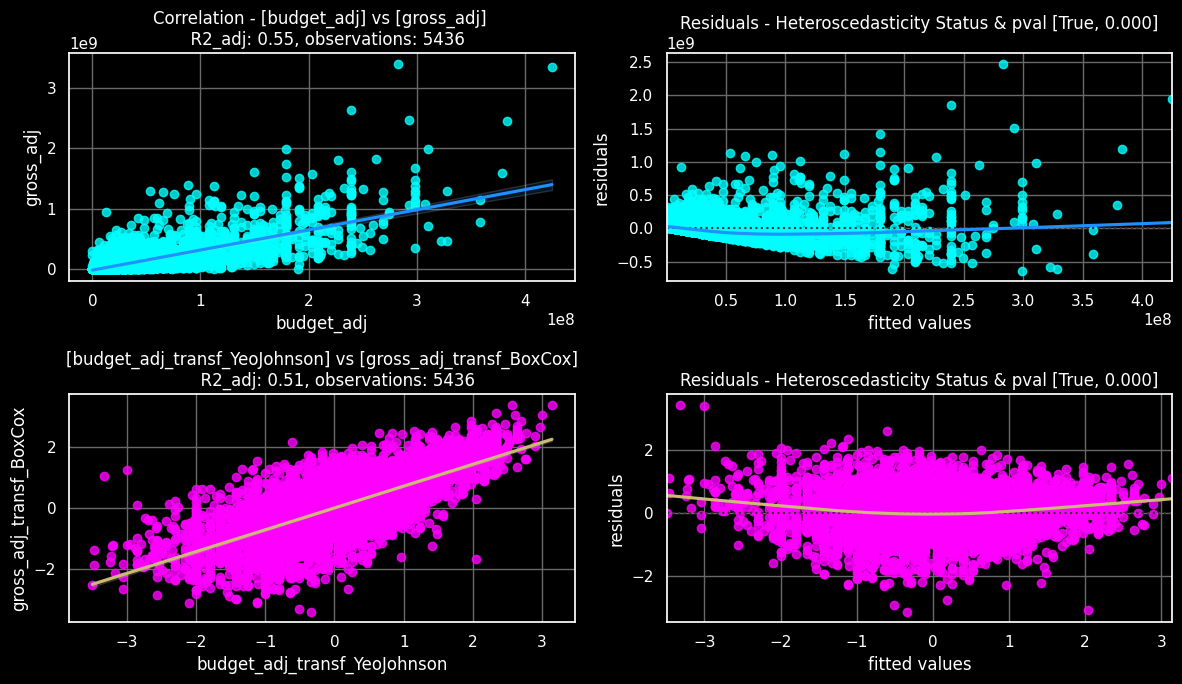

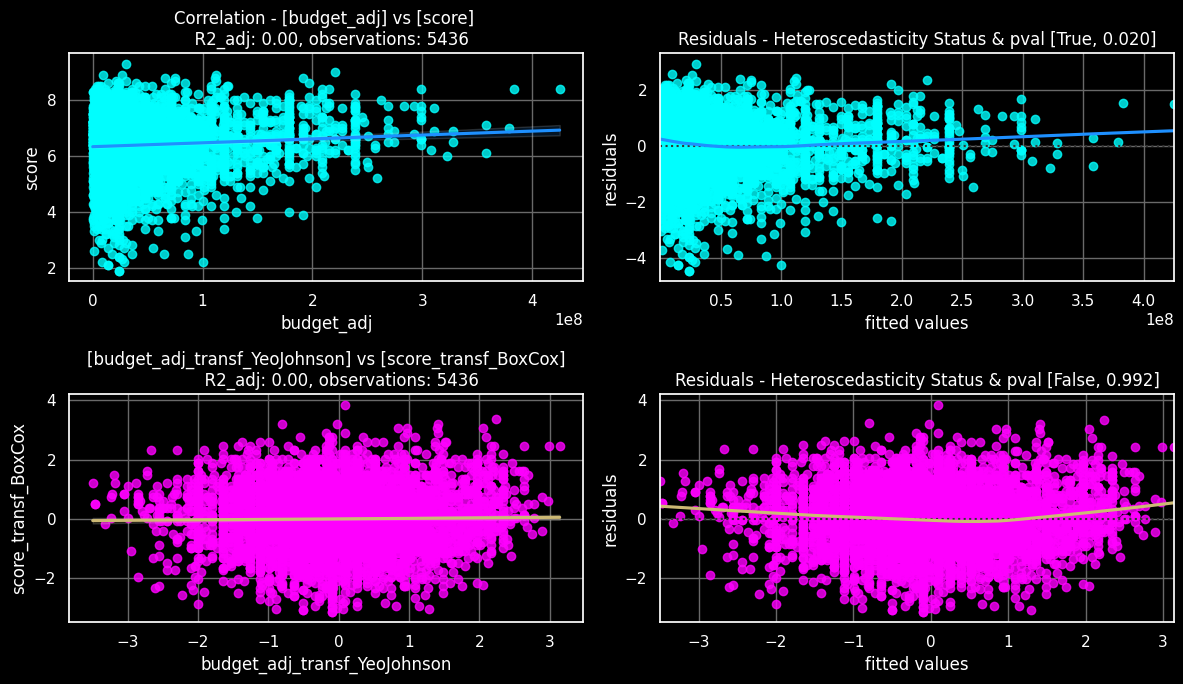

In [ ]:
### Exploring correlations - movie budget vs gross revenue; movie budget vs movie score
#-- when heteroscedasticity present, try regression of transformed versions of X and Y

#-- make function to get correlation metrics

def get_corr_metrics(df_x, name_Xvar_x, name_Yvar_x, CI_sig_x):
  dfr = df_x.copy().dropna(subset=[name_Xvar_x, name_Yvar_x], how='any')
  X_i = dfr[name_Xvar_x]
  Y_i = dfr[name_Yvar_x]
  X_i = sm.add_constant(X_i)
  num_pts_i = len(Y_i)
  model_i = sm.OLS(Y_i, X_i)
  results_i = model_i.fit()
  r_squared_adj_i = results_i.rsquared_adj
  intercept_i, slope_i = results_i.params

  BP_TestStat_i, BP_pval_i, BP_fval_i, BP_fval_pval_i = sms.het_breuschpagan(results_i.resid, results_i.model.exog)

  return r_squared_adj_i, BP_pval_i, num_pts_i

#-- run regressions

list_VarPairs = [['budget_adj','gross_adj'], ['budget_adj','score']]

thresh_pval = 0.05

for pair in list_VarPairs:
  xvar, yvar = pair[0], pair[1]
  r_squared_adj_i, BP_pval_i, num_pts_i = get_corr_metrics(df_x = dfs, name_Xvar_x=xvar, name_Yvar_x=yvar, CI_sig_x=0.95)

  bool_heteroscedastic_i = BP_pval_i < thresh_pval

  # plot

  from matplotlib import gridspec
  plt.style.context("dark_background")
  plt.style.use('dark_background')
  sns.set(rc={'axes.facecolor': 'k', 'figure.facecolor': 'k'})
  plt.style.use("dark_background")
  num_colors = 4
  color = plt.cm.cool(np.linspace(0, 1, num_colors))
  cyc = plt.cycler('color', color)
  plt.rc('axes', prop_cycle=cyc)

  fig = plt.figure(figsize=(12, 7))
  gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])
  ax3 = plt.subplot(gs[2])
  ax4 = plt.subplot(gs[3])

  title_scatter_corr = f"""Correlation - [{xvar}] vs [{yvar}]
  R2_adj: {r_squared_adj_i:.2f}, observations: {num_pts_i}"""
  title_scatter_resid = f'Residuals - Heteroscedasticity Status & pval [{bool_heteroscedastic_i}, {BP_pval_i:.3f}]'

  sns.regplot(data=dfs[[xvar, yvar]], x=xvar, y=yvar, ax=ax1, line_kws={"color": "dodgerblue"}).set(title=title_scatter_corr)
  sns.residplot(data=dfs[[xvar, yvar]], x=xvar, y=yvar, ax=ax2, lowess=True, line_kws=dict(color="dodgerblue")).set(title=title_scatter_resid)

  ax2.set(ylabel='residuals',xlabel='fitted values')

  if bool_heteroscedastic_i:

    if (len(dfs.filter(regex=f'{xvar}_transf').columns) > 0) & (len(dfs.filter(regex=f'{yvar}_transf').columns) > 0):
      Xcol_transf = dfs.filter(regex=f'{xvar}_transf').columns[0]
      Ycol_transf = dfs.filter(regex=f'{yvar}_transf').columns[0]
      r_squared_adj_ii, BP_pval_ii, num_pts_ii = get_corr_metrics(df_x = dfs, name_Xvar_x=Xcol_transf, name_Yvar_x=Ycol_transf, CI_sig_x=0.95)

      bool_heteroscedastic_ii = BP_pval_ii < thresh_pval

      title_scatter_corr_ii = f"""[{Xcol_transf}] vs [{Ycol_transf}]
      R2_adj: {r_squared_adj_ii:.2f}, observations: {num_pts_ii}"""
      title_scatter_resid_ii = f'Residuals - Heteroscedasticity Status & pval [{bool_heteroscedastic_ii}, {BP_pval_ii:.3f}]'

      sns.regplot(data=dfs[[Xcol_transf, Ycol_transf]], x=Xcol_transf, y=Ycol_transf, ax=ax3, scatter_kws={"color": "magenta"}, line_kws={"color": "y"}).set(title=title_scatter_corr_ii)
      sns.residplot(data=dfs[[Xcol_transf, Ycol_transf]], x=Xcol_transf, y=Ycol_transf, ax=ax4, lowess=True, scatter_kws={"color": "magenta"}, line_kws=dict(color="y")).set(title=title_scatter_resid_ii)

      ax4.set(ylabel='residuals',xlabel='fitted values')

    else:
      ax3.set_title('Adj Correlation - no transformed Xvar to use')
      ax4.set_title('Adj Residuals - no transformed Xvar to use')

  else:
    ax3.set_title('No adjustment for heterscedasticity needed')
    ax4.set_title('No adjustment for heterscedasticity needed')

  ax1.grid(c='dimgray')
  ax2.grid(c='dimgray')
  ax3.grid(c='dimgray')
  ax4.grid(c='dimgray')

  plt.tight_layout()



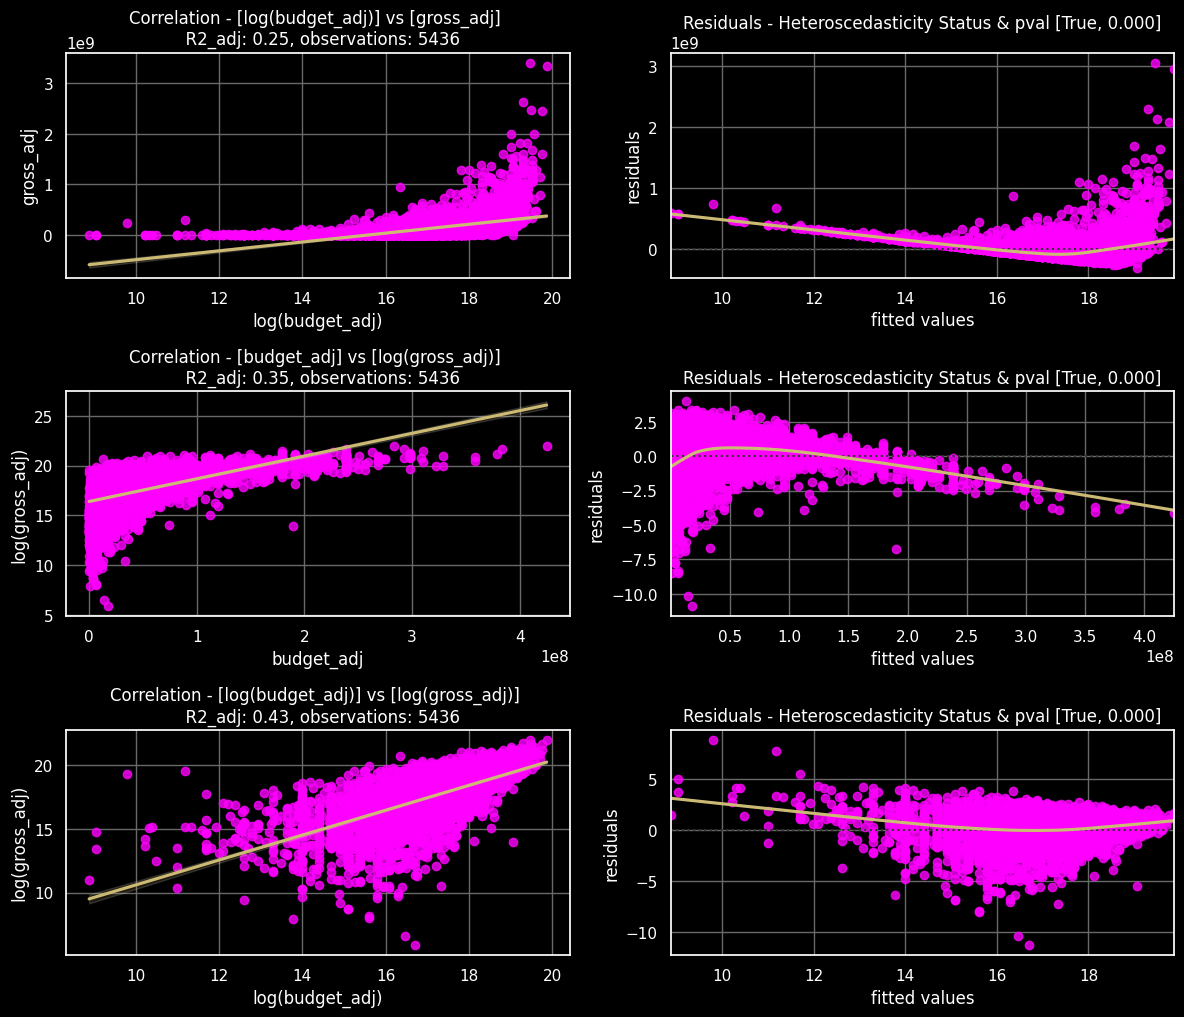

In [ ]:
### Exploring correlations; incorporate logarithms
#-- this time, try X vs log(Y), and log(X) vs Y, and log(X) vs log(Y)

#-- run regressions

list_VarPairs = [['budget_adj','gross_adj']]

thresh_pval = 0.05

for pair in list_VarPairs:
  xvar, yvar = pair[0], pair[1]

  # try taking logarithm of X

  dft = dfs[[xvar, yvar]].copy().dropna(subset=[xvar, yvar], how='any')

  xvar_log = f'log({xvar})'
  dft[xvar_log] = np.log(dft[xvar])

  yvar_log = f'log({yvar})'
  dft[yvar_log] = np.log(dft[yvar])

  res_i = smf.ols(formula=f'{yvar} ~ np.log({xvar})', data=dft).fit()
  r_squared_adj_i = res_i.rsquared_adj
  BP_TestStat_i, BP_pval_i, BP_fval_i, BP_fval_pval_i = sms.het_breuschpagan(res_i.resid, res_i.model.exog)
  num_pts_i = len(dft[xvar_log])
  bool_heteroscedastic_i = BP_pval_i < thresh_pval

  res_ii = smf.ols(formula=f'np.log({yvar}) ~ {xvar}', data=dft).fit()
  r_squared_adj_ii = res_ii.rsquared_adj
  BP_TestStat_ii, BP_pval_ii, BP_fval_ii, BP_fval_pval_ii = sms.het_breuschpagan(res_ii.resid, res_ii.model.exog)
  num_pts_ii = len(dft[xvar])
  bool_heteroscedastic_ii = BP_pval_ii < thresh_pval

  res_iii = smf.ols(formula=f'np.log({yvar}) ~ np.log({xvar})', data=dft).fit()
  r_squared_adj_iii = res_iii.rsquared_adj
  BP_TestStat_iii, BP_pval_iii, BP_fval_iii, BP_fval_pval_iii = sms.het_breuschpagan(res_iii.resid, res_iii.model.exog)
  num_pts_iii = len(dft[xvar_log])
  bool_heteroscedastic_iii = BP_pval_iii < thresh_pval

  # plot

  from matplotlib import gridspec
  plt.style.context("dark_background")
  plt.style.use('dark_background')
  sns.set(rc={'axes.facecolor': 'k', 'figure.facecolor': 'k'})
  plt.style.use("dark_background")
  num_colors = 4
  color = plt.cm.cool(np.linspace(0, 1, num_colors))
  cyc = plt.cycler('color', color)
  plt.rc('axes', prop_cycle=cyc)

  fig = plt.figure(figsize=(12, 10.5))
  gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])
  ax3 = plt.subplot(gs[2])
  ax4 = plt.subplot(gs[3])
  ax5 = plt.subplot(gs[4])
  ax6 = plt.subplot(gs[5])

  title_scatter_corr = f"""Correlation - [{xvar_log}] vs [{yvar}]
  R2_adj: {r_squared_adj_i:.2f}, observations: {num_pts_i}"""
  title_scatter_resid = f'Residuals - Heteroscedasticity Status & pval [{bool_heteroscedastic_i}, {BP_pval_i:.3f}]'

  sns.regplot(data=dft[[xvar_log, yvar]], x=xvar_log, y=yvar, ax=ax1, scatter_kws={"color": "magenta"}, line_kws=dict(color="y")).set(title=title_scatter_corr)
  sns.residplot(data=dft[[xvar_log, yvar]], x=xvar_log, y=yvar, ax=ax2, lowess=True, scatter_kws={"color": "magenta"}, line_kws=dict(color="y")).set(title=title_scatter_resid)

  title_scatter_corr_ii = f"""Correlation - [{xvar}] vs [{yvar_log}]
  R2_adj: {r_squared_adj_ii:.2f}, observations: {num_pts_ii}"""
  title_scatter_resid_ii = f'Residuals - Heteroscedasticity Status & pval [{bool_heteroscedastic_ii}, {BP_pval_ii:.3f}]'

  sns.regplot(data=dft[[xvar, yvar_log]], x=xvar, y=yvar_log, ax=ax3, scatter_kws={"color": "magenta"}, line_kws=dict(color="y")).set(title=title_scatter_corr_ii)
  sns.residplot(data=dft[[xvar, yvar_log]], x=xvar, y=yvar_log, ax=ax4, lowess=True, scatter_kws={"color": "magenta"}, line_kws=dict(color="y")).set(title=title_scatter_resid_ii)

  title_scatter_corr_iii = f"""Correlation - [{xvar_log}] vs [{yvar_log}]
  R2_adj: {r_squared_adj_iii:.2f}, observations: {num_pts_iii}"""
  title_scatter_resid_iii = f'Residuals - Heteroscedasticity Status & pval [{bool_heteroscedastic_iii}, {BP_pval_iii:.3f}]'

  sns.regplot(data=dft[[xvar_log, yvar_log]], x=xvar_log, y=yvar_log, ax=ax5, scatter_kws={"color": "magenta"}, line_kws=dict(color="y")).set(title=title_scatter_corr_iii)
  sns.residplot(data=dft[[xvar_log, yvar_log]], x=xvar_log, y=yvar_log, ax=ax6, lowess=True, scatter_kws={"color": "magenta"}, line_kws=dict(color="y")).set(title=title_scatter_resid_iii)

  ax1.grid(c='dimgray')
  ax2.grid(c='dimgray')
  ax3.grid(c='dimgray')
  ax4.grid(c='dimgray')
  ax5.grid(c='dimgray')
  ax6.grid(c='dimgray')

  ax2.set(ylabel='residuals',xlabel='fitted values')
  ax4.set(ylabel='residuals',xlabel='fitted values')
  ax6.set(ylabel='residuals',xlabel='fitted values')

  plt.tight_layout()





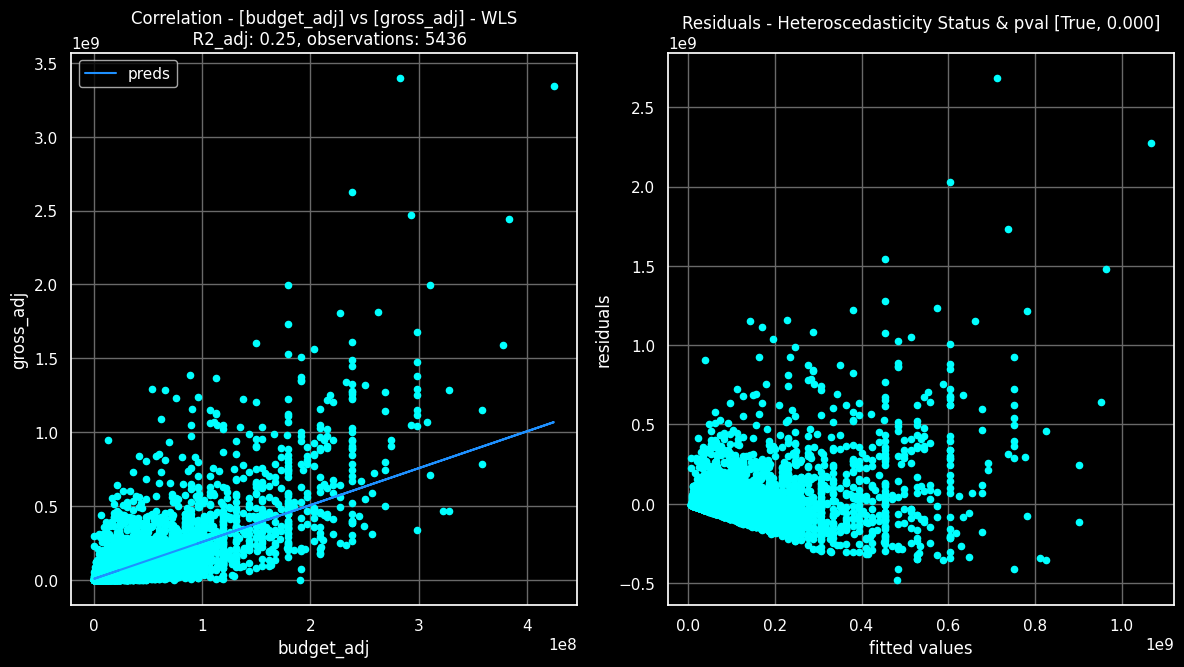

In [ ]:
### Exploring correlation: try WLS (weighted least squares)

#-- run regressions

list_VarPairs = [['budget_adj','gross_adj']]

thresh_pval = 0.05

for pair in list_VarPairs:

  xvar, yvar = pair[0], pair[1]

  # try taking logarithm of X

  dft = dfs[[xvar, yvar]].copy().dropna(subset=[xvar, yvar], how='any')

  w = dft[xvar] # np.ones(len(dft))

  Y_i = dft[yvar]
  X_i = dft[xvar]
  X_i = sm.add_constant(X_i)

  # get weights by starting with linear model

  fit = sm.OLS(Y_i, X_i).fit()
  wt = 1 / smf.ols('fit.resid.abs() ~ fit.fittedvalues', data=dft).fit().fittedvalues**2

  # now fit the WLS

  results_wls = sm.WLS(Y_i, X_i, weights=wt).fit()

  wls_preds = results_wls.predict(X_i)
  wls_resids = results_wls.resid

  dft['preds'] = wls_preds
  dft['resids'] = wls_resids

  r_squared_adj_i = results_wls.rsquared_adj
  BP_TestStat_i, BP_pval_i, BP_fval_i, BP_fval_pval_i = sms.het_breuschpagan(results_wls.resid, results_wls.model.exog)
  bool_heteroscedastic_i = BP_pval_i < thresh_pval
  num_pts_i = len(dft[xvar])

  # plot

  from matplotlib import gridspec
  plt.style.context("dark_background")
  plt.style.use('dark_background')
  sns.set(rc={'axes.facecolor': 'k', 'figure.facecolor': 'k'})
  plt.style.use("dark_background")
  num_colors = 4
  color = plt.cm.cool(np.linspace(0, 1, num_colors))
  cyc = plt.cycler('color', color)
  plt.rc('axes', prop_cycle=cyc)

  fig = plt.figure(figsize=(12, 7))
  gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[1, 1])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])

  title_scatter_corr_i = f"""Correlation - [{xvar}] vs [{yvar}] - WLS
  R2_adj: {r_squared_adj_i:.2f}, observations: {num_pts_i}"""

  title_scatter_resid_i = f'Residuals - Heteroscedasticity Status & pval [{bool_heteroscedastic_i}, {BP_pval_i:.3f}]'

  dft.plot.scatter(x=xvar, y=yvar, ax=ax1, title=title_scatter_corr_i)
  dft.plot(x=xvar, y='preds', ax=ax1, color='dodgerblue')

  dft.plot.scatter(x='preds', y='resids', ax=ax2, title=title_scatter_resid_i)

  ax1.grid(c='dimgray')
  ax2.grid(c='dimgray')

  ax2.set(ylabel='residuals',xlabel='fitted values')

  plt.tight_layout()


